<a href="https://colab.research.google.com/github/2kunal6/UniBonn/blob/master/cuda_lab/2/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Files already downloaded and verified
Files already downloaded and verified


  1%|          | 15/1407 [00:00<00:09, 145.65it/s]

datasets loaded
Running on the GPU


  1%|          | 14/1407 [00:00<00:10, 134.00it/s]

epoch: 0, loss: 2.432069778442383


100%|██████████| 1407/1407 [00:21<00:00, 65.10it/s]

epoch: 1, loss: 2.1139557361602783


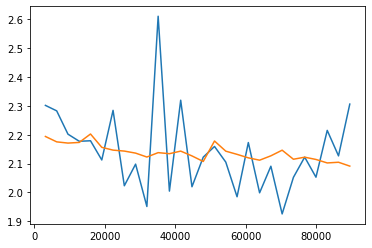

[[219   2 281   1  67  52   1  41  20 316]
 [100   9  60   6  14  42   4  23  94 648]
 [243   0 314   0  85 127   1  78  14 138]
 [182   1 216   0  37 302   2  63  13 184]
 [219   0 318   0  67 155   0  97   4 140]
 [153   1 198   5  28 409   0  71  13 122]
 [214   1 130   4  59 207   3 117  10 255]
 [202   0 322   0  45 114   1  58   6 252]
 [171   1 115   6  23 102   7  23  83 469]
 [ 91   6  45   2  22  26   1  11  42 754]]
Accuracy of the network on the 10000 test images: 19.16


In [18]:
import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

np.random.seed(1)

transform_list = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor()
            #transforms.Normalize([0.5,],[0.5,])
        ])
train = datasets.CIFAR10("./", train=True, transform=transform_list, download=True)

test = torch.utils.data.DataLoader(
    datasets.CIFAR10("./", train=False, transform=transform_list, download=True), batch_size = 32, shuffle = True
)

print("datasets loaded")

IMG_SIZE = 32*32

'''for data in train:
  X, y = data[0][0], data[1][0]
  plt.imshow(X.view(32, 32))
  print("Label: " + str(y))
  plt.show()
  break'''

class LogisticRegression(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(LogisticRegression, self).__init__()
    self.linear1 = nn.Linear(input_dim, 300)
    self.linear2 = nn.Linear(300, output_dim)
    self.relu = nn.ReLU()

  def forward(self, x):
    out = self.relu(self.linear1(x))
    out = self.linear2(out)
    return out

if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

model = LogisticRegression(IMG_SIZE, 10).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

criterion = nn.CrossEntropyLoss().to(device)

def test_perform(test_data):
  total = 0
  correct = 0

  y_true = []
  y_pred = []

  loss = 0.0
  i=0
  with torch.no_grad():
    for data in test_data:
      X, y = data[0].to(device), data[1].to(device)

      output = model(X.view(-1, IMG_SIZE))
      _, predicted = torch.max(output, 1)

      loss += criterion(output, y)

      total += y.size(0)
      correct += (predicted == y).sum().item()

      y_pred.extend(predicted.tolist())
      y_true.extend(y.tolist())

      i+=1

    accuracy = 100 * correct / total
    return accuracy, y_true, y_pred, loss/i

BATCH_SIZE = 32

loss_train = []
loss_val = []
iter_list = []
iter_num = 0

for epoch in range(2):
  train_size = int(0.9 * len(train))
  val_size = len(train) - train_size
  train_dataset, val_dataset = torch.utils.data.random_split(train, [train_size, val_size])
  train_loader = torch.utils.data.DataLoader(train_dataset,batch_size = BATCH_SIZE, shuffle = True)
  val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True)

  for data in tqdm(train_loader):
    X, y = data[0].to(device), data[1].to(device)
    
    optimizer.zero_grad()
    
    output = model(X.view(-1, IMG_SIZE))
    
    loss = criterion(output, y)
    
    loss.backward()
    
    optimizer.step()
    
    iter_num+=BATCH_SIZE

    if(iter_num%(BATCH_SIZE*100) == 0):
      _, _, _, val_loss = test_perform(val_loader)

      iter_list.append(iter_num)
      loss_train.append(loss)
      loss_val.append(val_loss)

    
  print(f'epoch: {epoch}, loss: {loss}')

plt.plot(iter_list, loss_train)
plt.plot(iter_list, loss_val)
plt.show()

    
accuracy, y_true, y_pred, _ = test_perform(test)

print(confusion_matrix(y_true, y_pred))
print(f'Accuracy of the network on the 10000 test images: {accuracy}')